In [1]:
# import jax
# import time
# import numpy

# # a = numpy.random.normal(size=(10000,10000))
# # b = numpy.random.normal(size=(10000,10000))
# # a = jax.random.normal(key=jax.random.PRNGKey(1000), shape=(10000,10000))
# # b = jax.random.normal(key=jax.random.PRNGKey(10004), shape=(10000,10000))

# # def c():
# #     return jax.numpy.matmul(a,b).mean()

# def timeit(func):

#     toc = time.time()
#     func()
#     tic = time.time()
#     print(f"Time: {tic-toc}")

# # timeit(c)

In [2]:
import mdtraj as md
import numpy as np
trajectory2 = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')
topology = trajectory2.top
table, bonds = topology.to_dataframe()
# print(table[:40])

mass_of = {'H' : 1.00784, 'N': 14.0067, 'O': 15.999, 'C' : 12.011}

alanine_dipeptide_mass = sum(mass_of[atom] for atom in list(table['element'][:22]))
alanine_dipeptide_mass

water_mass = sum(mass_of[atom] for atom in ['H', 'H', 'O'])
water_mass

molecule_mass_of = {'ACE' : alanine_dipeptide_mass, 'NME' : alanine_dipeptide_mass, 'ALA' : alanine_dipeptide_mass, "HOH" : water_mass}

masses = np.array([molecule_mass_of[molecule] for molecule in (table['resName'])])
print(masses)

[144.17148 144.17148 144.17148 144.17148 144.17148 144.17148 144.17148
 144.17148 144.17148 144.17148 144.17148 144.17148 144.17148 144.17148
 144.17148 144.17148 144.17148 144.17148 144.17148 144.17148 144.17148
 144.17148  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468
  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468
  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468
  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468
  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468
  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468
  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468
  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468
  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468
  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468
  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468  18.01468
  18.0

Time: 0.0002014636993408203

In [29]:
from moleculekit.molecule import Molecule
import jax_md
import os
from parameters import Parameters, set_box, set_positions
import jax.numpy as nnp
from torchmd.forcefields.forcefield import ForceField
import numpy.linalg as npl
import seaborn as sns
import matplotlib.pyplot as plt 
from plotting import rama_plot
from jax_md.simulate import Sampler
from jax_md import space, quantity
from jax_md import simulate, energy
from jax_md.simulate import ess_corr
import math
import jax
import scipy
import mdtraj as md

# load alanine dipeptide
testdir = "data/prod_alanine_dipeptide_amber/"
mol = Molecule(os.path.join(testdir, "structure.prmtop"))  # Reading the system topology
mol.read(os.path.join(testdir, "input.coor"))  # Reading the initial simulation coordinates
mol.read(os.path.join(testdir, "input.xsc"))  # Reading the box dimensions

2023-06-30 16:22:22,296 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-30 16:22:22,297 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-30 16:22:22,298 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-06-30 16:22:22,299 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-06-30 16:22:22,299 - jax._src.xla_bridge - WARNING - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [30]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [31]:
ff = ForceField.create(mol, os.path.join(testdir, "structure.prmtop"))
parameters = Parameters(ff, mol, precision=float, device='cpu')
nreplicas = 1 # don't change
pos = set_positions(nreplicas, mol.coords)
box = nnp.array(set_box(nreplicas, mol.box), dtype='float32')

from forces import Forces
forces = Forces(parameters, cutoff=9, rfa=True, switch_dist=7.5, terms=["bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj"])
forces.compute(pos, box)

/global/homes/r/reubenh/.conda/envs/py38/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/global/homes/r/reubenh/.conda/envs/py38/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/global/homes/r/reubenh/.conda/envs/py38/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incomp

Array(-2190.62312837, dtype=float64)

In [5]:
# timeit(lambda : forces.compute(pos,box))

Time: 3.4152863025665283

Calculating the potential should result in the same value, -2190.6, as the original TorchMD code at https://github.com/torchmd/torchmd/blob/master/examples/tutorial.ipynb:

In [32]:

# displacement_fn, shift_fn = space.periodic_general(box[0])

psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]


In [7]:
# import jax.numpy as jaxnum 
# import jax.numpy.linalg as jaxnuml

# def wrap_dist(dist, box):
#     # return dist 
#     return jax.lax.cond(box is None or jaxnum.all(box == 0),
             
#         lambda d : d, 
#         lambda d: d - jaxnum.expand_dims(box,0) * jaxnum.round(dist / jaxnum.expand_dims(box,0)),
#         dist)

# def calculate_distances(atom_pos, atom_idx, box):
    
#     # direction_vec = wrap_dist(atom_pos[atom_idx[:, 0]] - atom_pos[atom_idx[:, 1]], box)
#     direction_vec = wrap_dist(jaxnum.take(atom_pos,atom_idx[:, 0], axis=0) - jaxnum.take(atom_pos, atom_idx[:, 1], axis=0), box)

#     # print(direction_vec, "DIR VEC")
#     # print(atom_pos, "ATOM POS")
#     # print(atom_idx, "ATOM IDX")
#     dist = jaxnuml.norm(direction_vec, axis=1)
#     # print(dist, 'DIST')
#     direction_unitvec = direction_vec / jaxnum.expand_dims(dist,1)
#     return dist, direction_unitvec, direction_vec

# def evaluate_torsion(r12, r23, r34, torsion_params):
#     # Calculate dihedral angles from vectors
#     crossA = jaxnum.cross(r12, r23, axis=1)
#     crossB = jaxnum.cross(r23, r34, axis=1)
#     crossC = jaxnum.cross(r23, crossA, axis=1)
#     normA = jaxnuml.norm(crossA, axis=1)
#     normB = jaxnuml.norm(crossB, axis=1)
#     normC = jaxnuml.norm(crossC, axis=1)
#     normcrossB = crossB / jaxnum.expand_dims(normB,1)
#     cosPhi = jaxnum.sum(crossA * normcrossB, axis=1) / normA
#     sinPhi = jaxnum.sum(crossC * normcrossB, axis=1) / normC
#     phi = -jaxnum.arctan2(sinPhi, cosPhi)


#     ntorsions = len(torsion_params[0]["idx"])
#     pot = jaxnum.zeros(ntorsions, dtype=r12.dtype)


In [8]:
# timeit(lambda : forces.compute(pos,box))

In [9]:
# _, _, r12 = calculate_distances(
#                 pos[0], forces.par.dihedrals[:, [0, 1]], nnp.diagonal(box[0])
#             )
# print(r12.shape)

# r12 = nnp.ones((10000000, 3))+2

# timeit(lambda: evaluate_torsion(
#                 r12, r12, r12, forces.par.dihedral_params
#             ))

# # timeit(lambda: forces.compute(pos, box))

cpu: Time: 0.32874393463134766

gpu: Time: 0.0008893013000488281

cpu: 

Time: 0.28463244438171387

Time: 0.41229891777038574

In [10]:
def run_mclmc(T, dt, L_factor, chain_length, gamma):

    print(f'Comparison of MCLMC and Langevin, at T={T}, dt={dt}, and with {chain_length} steps ')
    
    fig, axs = plt.subplots(1,2, figsize=(8, 4))
    axs[0].set_xlim(-math.pi, math.pi)
    axs[0].set_ylim(-math.pi, math.pi)
    axs[1].set_xlim(-math.pi, math.pi)
    axs[1].set_ylim(-math.pi, math.pi)
    axs[0].title.set_text('MCLMC')
    axs[1].title.set_text('Langevin')

    BOLTZMAN = 0.001987191

    a = jax.random.normal(key=jax.random.PRNGKey(26), shape=(2064,10000))

    # nlogp = lambda x : nnp.dot(x,a).mean()
    nlogp = (lambda x : forces.compute(nnp.reshape(x, pos.shape), box))
    energy_fn = lambda x : nlogp(x) / (BOLTZMAN * T)
    value_grad = jax.jit(jax.value_and_grad(energy_fn))

    class MD():


        def __init__(self, d):
            self.d = d
            self.nbrs = None

        def grad_nlogp(self, x):
            return value_grad(x)

        def transform(self, x):
            return x

        def prior_draw(self, key):
            return nnp.array(nnp.reshape(pos, math.prod(pos.shape)), dtype='float64')


    displacement_fn, shift_fn = space.periodic(box[0][0][0].item())

    eps_in_si = dt*scipy.constants.femto * nnp.sqrt(3 * 688 * scipy.constants.k * T)
    si_to_gmol = nnp.sqrt(1000*scipy.constants.Avogadro)/scipy.constants.angstrom
    eps = eps_in_si * si_to_gmol

    target = MD(d = math.prod(pos.shape))
    # sampler = Sampler(target, shift_fn=shift_fn, masses = jax.numpy.tile(mol.masses,3), frac_tune1=0.0, frac_tune2=0.0, frac_tune3=0.0, L = L_factor*eps,
                #   eps=eps)
    sampler = Sampler(target, shift_fn=shift_fn, masses = jax.numpy.ones(2064,), frac_tune1=0.0, frac_tune2=0.0, frac_tune3=0.0, L = L_factor*eps,
                  eps=eps)
    num_chains = 1
    samples, energy, L, _ = sampler.sample(chain_length, num_chains, output= 'detailed')



    subsampled = samples[::10, :]
    trajectory = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')
    trajectory.xyz=nnp.array(nnp.reshape(subsampled, (subsampled.shape[0], 688, 3)))[::1]
    unitC = nnp.array([(subsampled.shape[0])*[nnp.diag(mol.box[:,0])]]).squeeze()
    trajectory.unitcell_vectors = unitC # traj.unitcell_vectors[:10000]
    angles = md.compute_dihedrals(trajectory, [phi_indices, psi_indices])

    sns.scatterplot(x = angles[:, 0], y = angles[:, 1], ax=axs[0], s=5)
    
    # plt.show()

    print("MCLMC\n\n")

    print("L: ", L)
    print("eps: ", eps)

    rmses = nnp.sqrt(nnp.mean(samples**2, axis=0))
    print("Mean RMS: ", rmses.mean())
    print("Max RMS: ", nnp.max(rmses))
    print("Min RMS: ", nnp.min(rmses))
    print("Energy error: ", (nnp.square(energy[1:]-energy[:-1])/math.prod(pos.shape)).mean())

    print("ESS (via ess_corr): ", ess_corr(samples))


    # name = 'mclmc' + str(eps) + str(L) + str(num_chains)
    # trajectory.save_pdb('./data/prod_alanine_dipeptide_amber/traj'+name+'.pdb')


    ##### LANGEVIN

    key = jax.random.PRNGKey(0)


    dt = dt * 1e-3
    init, update = simulate.nvt_langevin(nlogp, shift_fn, dt, kT=BOLTZMAN*T, gamma=gamma)
    state = init(key, pos)
    samples_langevin = []

    for i in range(chain_length):
        if i%10==0:
            samples_langevin.append(state.position)
        state = update(state)


    trajectory2 = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')
    trajectory2.xyz=nnp.array(nnp.array(samples_langevin).squeeze())[::1]
    unitC = nnp.array([(len(samples_langevin))*[nnp.diag(mol.box[:,0])]]).squeeze()
    trajectory2.unitcell_vectors = unitC
    angles_langevin = md.compute_dihedrals(trajectory2, [phi_indices, psi_indices])
    sns.scatterplot(x = angles_langevin[:, 0], y = angles_langevin[:, 1], ax=axs[1], s=5)

    # name2 = 'mclmc' + str(dt) + str(gamma) + str(num_chains)
    # trajectory2.save_pdb('./data/prod_alanine_dipeptide_amber/traj'+name2+'.pdb')



    print("Langevin\n\n")
    print("Gamma: ", gamma)

    return samples,energy, L, eps, samples_langevin, gamma


Comparison of MCLMC and Langevin, at T=4000, dt=2, and with 1000 steps 
Energy is 
 0.0
Energy is 
 49.66485165632287
Energy is 
 60.43466101125226
Energy is 
 62.450322132112426
Energy is 
 63.69336334376216
Energy is 
 73.67821752462328
Energy is 
 99.60270915637744
Energy is 
 105.13526901563793
Energy is 
 93.59314894138251
Energy is 
 114.61880044341694
Energy is 
 134.90404663567722
Energy is 
 119.54460005386946
Energy is 
 132.79003081806593
Energy is 
 140.0619233303942
Energy is 
 152.32446664582977
Energy is 
 182.61554913751672
Energy is 
 168.98634228143175
Energy is 
 168.31555826355782
Energy is 
 198.64514758945842
Energy is 
 223.3680662135194
Energy is 
 230.61266202812044
Energy is 
 230.6737908951199
Energy is 
 251.3217372027887
Energy is 
 266.8841507445975
Energy is 
 283.1311324684419
Energy is 
 290.90632702114266
Energy is 
 324.28191682484254
Energy is 
 352.54041632737267
Energy is 
 367.19594530236185
Energy is 
 383.82697457925576
Energy is 
 386.750458408

/global/homes/r/reubenh/.conda/envs/py38/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


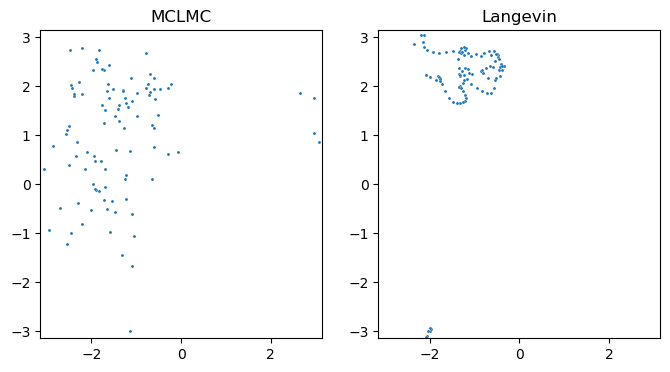

In [7]:
x_initial,energy,L,eps, samples_langevin, gamma = run_mclmc(T=4000, dt=2, L_factor=30, chain_length=1000, gamma=0.1)

In [29]:
rmses = nnp.sqrt(nnp.mean((samples)**2, axis=0))
print("Mean RMS: ", rmses.mean())
print("Max RMS: ", nnp.max(rmses))
print("Min RMS: ", nnp.min(rmses))
print(f"Condition number {nnp.square(nnp.max(rmses)/nnp.min(rmses))}")

Mean RMS:  10.33761818226038
Max RMS:  18.905610919165007
Min RMS:  1.184260297623826
Condition number 254.85144009963847


In [25]:
rmses = nnp.sqrt(nnp.mean((samples)**2, axis=0))
print("Mean RMS: ", rmses.mean())
print("Max RMS: ", nnp.max(rmses))
print("Min RMS: ", nnp.min(rmses))
print(f"Condition number {nnp.square(nnp.max(rmses)/nnp.min(rmses))}")

Mean RMS:  10.413960915781889
Max RMS:  18.97668868212388
Min RMS:  1.1454534293428185
Condition number 274.46438164128705


In [26]:
masses = jax.numpy.tile(mol.masses,3) # per dimension
sigma = 1/nnp.sqrt(masses)
rmses = nnp.sqrt(nnp.mean((samples/sigma)**2, axis=0))
print("Mean RMS: ", rmses.mean())
print("Max RMS: ", nnp.max(rmses))
print("Min RMS: ", nnp.min(rmses))
print(f"Condition number {nnp.square(nnp.max(rmses)/nnp.min(rmses))}")

Mean RMS:  20.91020191548034
Max RMS:  75.90675472849551
Min RMS:  1.2199476117929957
Condition number 3871.4930697410855


Comparison of MCLMC and Langevin, at T=300, dt=0.1, and with 1000 steps 
MCLMC


L:  2.1525528397334264
eps:  0.07175176132444755
Mean RMS:  10.131701044958454
Max RMS:  19.713735185523497
Min RMS:  0.11852189527020833
Energy error:  0.005091554099974358
ESS (via ess_corr):  0.004712478629185076


/global/homes/r/reubenh/.conda/envs/py38/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


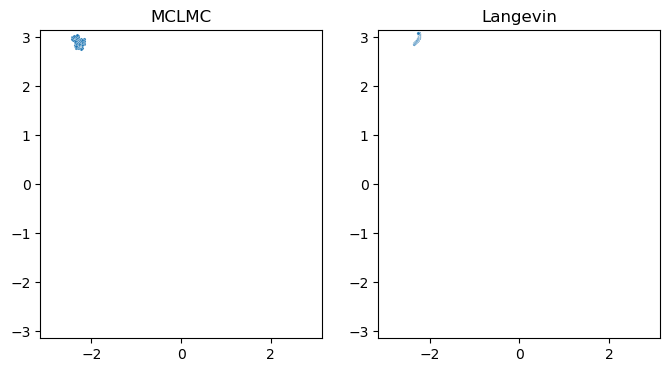

In [11]:
# samples,energy,L,eps, samples_langevin, gamma = run_mclmc(T=300, dt=(1e3*1.5)/48.0, L_factor=3000, chain_length=1000, gamma=0.1/(1000/48))
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(T=300, dt=0.1, L_factor=30, chain_length=1000, gamma=0.1)

(1000, 2064)

Comparison of MCLMC and Langevin, at T=300, dt=2.0, and with 100000 steps 
MCLMC


L:  43.05105679466853
eps:  1.435035226488951
RMS:  10.350705074787406
Energy error:  0.3797169333834338
ESS (via ess_corr):  8.200293367054742e-05


/global/homes/r/reubenh/.conda/envs/py38/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


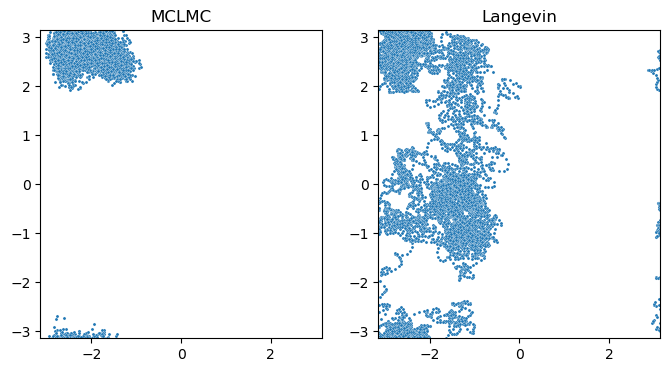

In [16]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(T=300, dt=2.0, L_factor=30, chain_length=100000, gamma=0.1)

Comparison of MCLMC and Langevin, at T=300, dt=2.0, and with 100000 steps 
MCLMC


L:  4305.105679466853
eps:  1.435035226488951
Mean RMS:  10.72143513053902
Max RMS:  18.671955315714957
Min RMS:  1.4034368390258998
Energy error:  0.755246799177994
ESS (via ess_corr):  6.685379724638053e-05


/global/homes/r/reubenh/.conda/envs/py38/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  1.0


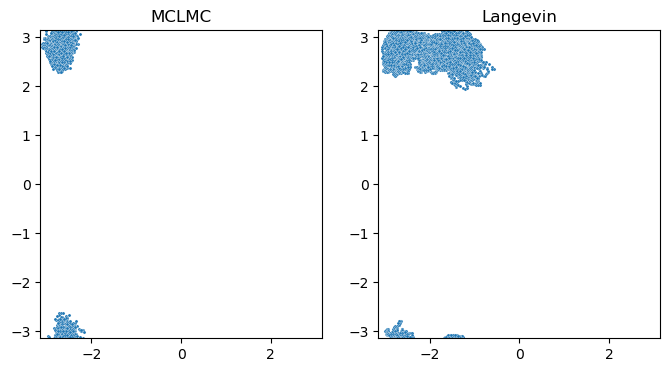

In [6]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(T=300, dt=2.0, L_factor=3000, chain_length=100000, gamma=1.0)

Comparison of MCLMC and Langevin, at T=300, dt=2.0, and with 100000 steps 
MCLMC


L:  430.5105679466853
eps:  1.435035226488951
RMS:  10.665069984874036
Energy error:  0.5889184609037759
ESS (via ess_corr):  6.827843286681332e-05


/global/homes/r/reubenh/.conda/envs/py38/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  1.0


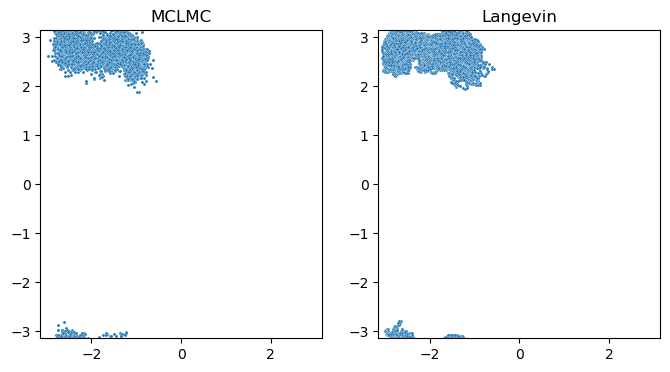

In [17]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(T=300, dt=2.0, L_factor=300, chain_length=100000, gamma=1.0)

(Note: I can rerun the following with smaller dots on the scatterplots but haven't yet as these took a few hours.)

Comparison of MCLMC and Langevin, at T=300, dt=8, and with 1000 steps 
MCLMC


L:  172.20422717867413
eps:  5.740140905955804
RMS:  10.115942419726904
Energy error:  40105.041800953244
ESS (via ess_corr):  0.003744023411434403


/global/homes/r/reubenh/.conda/envs/py38/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


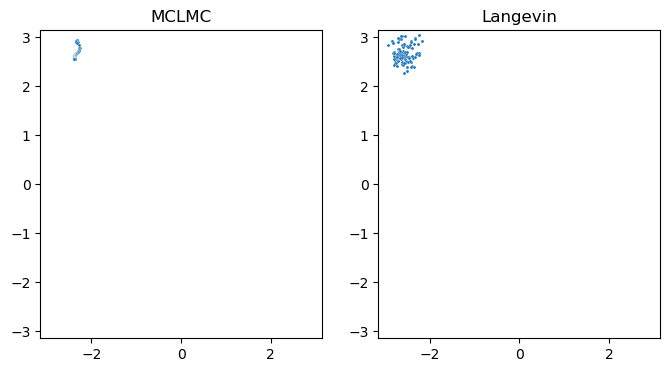

In [18]:
samples,energy,L,eps, samples_langevin, gamma = run_mclmc(T=300, dt=8, L_factor=30, chain_length=1000, gamma=0.1)

Comparison of MCLMC and Langevin, at T=4000, dt=2, and with 1000 steps 
Energy is 
 0.0
Energy is 
 49.66485165632287
Energy is 
 60.43466101125226
Energy is 
 62.450322132112426
Energy is 
 63.69336334376216
Energy is 
 73.67821752462328
Energy is 
 99.60270915637744
Energy is 
 105.13526901563793
Energy is 
 93.59314894138251
Energy is 
 114.61880044341694
Energy is 
 134.90404663567722
Energy is 
 119.54460005386946
Energy is 
 132.79003081806593
Energy is 
 140.0619233303942
Energy is 
 152.32446664582977
Energy is 
 182.61554913751672
Energy is 
 168.98634228143175
Energy is 
 168.31555826355782
Energy is 
 198.64514758945842
Energy is 
 223.3680662135194
Energy is 
 230.61266202812044
Energy is 
 230.6737908951199
Energy is 
 251.3217372027887
Energy is 
 266.8841507445975
Energy is 
 283.1311324684419
Energy is 
 290.90632702114266
Energy is 
 324.28191682484254
Energy is 
 352.54041632737267
Energy is 
 367.19594530236185
Energy is 
 383.82697457925576
Energy is 
 386.750458408

/global/homes/r/reubenh/.conda/envs/py38/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Langevin


Gamma:  0.1


(1000, 2064)

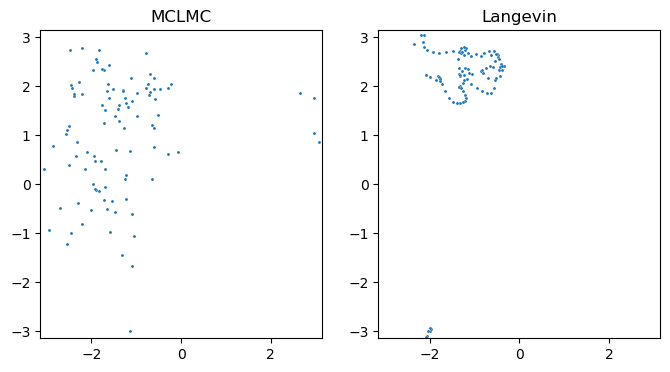

In [11]:
x_initial,energy,L,eps, samples_langevin, gamma = run_mclmc(T=4000, dt=2, L_factor=30, chain_length=1000, gamma=0.1)

x_initial.shape

# SMC

In [33]:
# from jax_md.simulate import SMCSampler
from sampling.annealing import Sampler as AnnealingSampler
from sampling.dynamics import systematic_resampling

def run_smc():

    # print(f'Comparison of MCLMC and Langevin, at T={T}, dt={dt}, and with {chain_length} steps ')
    
    # fig, axs = plt.subplots(1,2, figsize=(8, 4))
    # axs[0].set_xlim(-math.pi, math.pi)
    # axs[0].set_ylim(-math.pi, math.pi)
    # axs[1].set_xlim(-math.pi, math.pi)
    # axs[1].set_ylim(-math.pi, math.pi)
    # axs[0].title.set_text('MCLMC')
    # axs[1].title.set_text('Langevin')

    BOLTZMAN = 0.001987191

    nlogp = lambda x : forces.compute(nnp.reshape(x, pos.shape), box)
    energy_fn = lambda x : nlogp(x) # / (BOLTZMAN * T)

    # energy_fn = lambda x : ((x**2)/2).sum() # / (BOLTZMAN * T)
    value_grad = jax.value_and_grad(energy_fn)

    class MD():


        def __init__(self, d):
            self.d = d
            self.nbrs = None

        def grad_nlogp(self, x):
            return value_grad(x)

        def transform(self, x):
            return x

        def prior_draw(self, key):
            return nnp.array(nnp.reshape(pos, math.prod(pos.shape)), dtype='float64')


    displacement_fn, shift_fn = space.periodic(box[0][0][0].item())


    eps_in_si = 2.0*scipy.constants.femto * nnp.sqrt(3 * 688 * scipy.constants.k * 300.0)
    si_to_gmol = nnp.sqrt(1000*scipy.constants.Avogadro)/scipy.constants.angstrom
    eps = eps_in_si * si_to_gmol

    target = MD(d = math.prod(pos.shape))
    sampler = AnnealingSampler(target, shift_fn=shift_fn)

    def temp_func(T,Tprev, L, eps):

        dt = 2
        eps_in_si = dt*scipy.constants.femto * nnp.sqrt(3 * 688 * scipy.constants.k * (T/BOLTZMAN))
        si_to_gmol = nnp.sqrt(1000*scipy.constants.Avogadro)/scipy.constants.angstrom
        eps = eps_in_si * si_to_gmol

        return eps*30, eps
    
    sampler.temp_func = temp_func

    def resample_particles(logw, x, u, l, g, key, L, eps, T):

            indices, key = systematic_resampling(logw*0.01, key)
            jax.debug.print("indices {}", indices)
            jax.debug.print("logw {}", logw)
            # indices = nnp.array([0,0,0,0,0,0,0,0,0,0])

            x_resampled = nnp.take(x, indices, axis=0)
            u_resampled = nnp.take(u, indices, axis=0)
            l_resampled = nnp.take(l, indices)
            g_resampled = nnp.take(g, indices, axis=0)

            return (x_resampled, u_resampled, l_resampled, g_resampled, key, L, eps, T)

    sampler.resample_particles = resample_particles

    # sampler.eps_initial = eps
    # sampler.L = eps*30
                         
                #          masses = jax.numpy.tile(mol.masses,3), frac_tune1=0.0, frac_tune2=0.0, frac_tune3=0.0, L = L_factor*eps,
                #   eps=eps)
    samples, energy = sampler.sample(num_temps=5, steps_at_each_temp=1000, temp_schedule=(BOLTZMAN*4000,BOLTZMAN*300), ess=0.5, num_chains=10, tune_steps=0, random_key=jax.random.PRNGKey(42), x_initial=x_initial[::100])   

    print("samples shape", samples.shape)

    def pl(i):

        subsampled = nnp.reshape(samples[i], (1000, 2064))
        trajectory = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')
        trajectory.xyz=nnp.array(nnp.reshape(subsampled, (subsampled.shape[0], 688, 3)))[::1]
        unitC = nnp.array([(subsampled.shape[0])*[nnp.diag(mol.box[:,0])]]).squeeze()
        trajectory.unitcell_vectors = unitC # traj.unitcell_vectors[:10000]
        angles = md.compute_dihedrals(trajectory, [phi_indices, psi_indices])

        sns.scatterplot(x = angles[:, 0], y = angles[:, 1], s=2)
        plt.xlim(-math.pi, math.pi)
        plt.ylim(-math.pi, math.pi)

    pl(0)
    pl(1)
    pl(2)
    pl(3)
    pl(4)
    # pl(5)
    # pl(6)
    # pl(19)

    return samples 

In [34]:
samples = run_smc()

# Annealing Sampler

In [14]:
# from jax_md.old_annealing_sampler import Sampler as AnnealingSampler
from sampling.annealing import Sampler as AnnealingSampler
from sampling.dynamics import resample_particles, systematic_resampling

def run_annealing(chain_length, num_chains):

    # print(f'Comparison of MCLMC and Langevin, at T={T}, dt={dt}, and with {chain_length} steps ')
    
    # fig, axs = plt.subplots(1,2, figsize=(8, 4))
    # axs[0].set_xlim(-math.pi, math.pi)
    # axs[0].set_ylim(-math.pi, math.pi)
    # axs[1].set_xlim(-math.pi, math.pi)
    # axs[1].set_ylim(-math.pi, math.pi)
    # axs[0].title.set_text('MCLMC')
    # axs[1].title.set_text('Langevin')

    BOLTZMAN = 0.001987191

    nlogp = lambda x : forces.compute(nnp.reshape(x, pos.shape), box)
    energy_fn = lambda x : nlogp(x) # / (BOLTZMAN * T)

    # energy_fn = lambda x : ((x**2)/2).sum() # / (BOLTZMAN * T)
    value_grad = jax.value_and_grad(energy_fn)

    class MD():


        def __init__(self, d):
            self.d = d
            self.nbrs = None

        def grad_nlogp(self, x):
            return value_grad(x)

        def transform(self, x):
            return x

        def prior_draw(self, key):
            return nnp.array(nnp.reshape(pos, math.prod(pos.shape)), dtype='float64')


    displacement_fn, shift_fn = space.periodic(box[0][0][0].item())

    # eps_in_si = dt*scipy.constants.femto * nnp.sqrt(3 * 688 * scipy.constants.k * T)
    # si_to_gmol = nnp.sqrt(1000*scipy.constants.Avogadro)/scipy.constants.angstrom
    # eps = eps_in_si * si_to_gmol

    target = MD(d = math.prod(pos.shape))
    # sampler = AnnealingSampler(target, shift_fn=shift_fn) # , masses=jax.numpy.tile(mol.masses,3))
    # sampler = AnnealingSampler(target, shift_fn=shift_fn, masses=jax.numpy.tile(mol.masses,3))
    sampler = AnnealingSampler(target, shift_fn=shift_fn)

    def temp_func(T,Tprev, L, eps):

        dt = 2
        eps_in_si = dt*scipy.constants.femto * nnp.sqrt(3 * 688 * scipy.constants.k * (T/BOLTZMAN))
        si_to_gmol = nnp.sqrt(1000*scipy.constants.Avogadro)/scipy.constants.angstrom
        eps = eps_in_si * si_to_gmol

        return eps*30, eps
    
    sampler.temp_func = temp_func

    def resample_particles(logw, x, u, l, g, key, L, eps, T):

            indices, key = systematic_resampling(logw*0.01, key)
            jax.debug.print("indices {}", indices)
            jax.debug.print("logw {}", logw)
            # indices = nnp.array([0,0,0,0,0,0,0,0,0,0])

            x_resampled = nnp.take(x, indices, axis=0)
            u_resampled = nnp.take(u, indices, axis=0)
            l_resampled = nnp.take(l, indices)
            g_resampled = nnp.take(g, indices, axis=0)

            return (x_resampled, u_resampled, l_resampled, g_resampled, key, L, eps, T)

    sampler.resample_particles = resample_particles

    # dt = 2
    # T = 300
    # eps_in_si = dt*scipy.constants.femto * nnp.sqrt(3 * 688 * scipy.constants.k * T)
    # si_to_gmol = nnp.sqrt(1000*scipy.constants.Avogadro)/scipy.constants.angstrom
    # eps = eps_in_si * si_to_gmol

    # sampler.L = 30*eps
    # sampler.eps_initial = eps
                         
                #          masses = jax.numpy.tile(mol.masses,3), frac_tune1=0.0, frac_tune2=0.0, frac_tune3=0.0, L = L_factor*eps,
                #   eps=eps)
    samples, energy = sampler.sample(steps_at_each_temp=chain_length, temp_schedule=nnp.array([4000.0*BOLTZMAN, 370*BOLTZMAN, 300*BOLTZMAN]), num_chains=num_chains, tune_steps=0, random_key=jax.random.PRNGKey(42))
    # , x_initial=x_initial[::50])  

    print(samples.shape, "shape\n\n\n") 
    print(energy.shape)

    def pl(i):

        subsampled = nnp.reshape(samples[i], (chain_length*num_chains, 2064))
        print(subsampled.shape, "shape")
        trajectory = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')
        trajectory.xyz=nnp.array(nnp.reshape(subsampled, (subsampled.shape[0], 688, 3)))[::1]
        unitC = nnp.array([(subsampled.shape[0])*[nnp.diag(mol.box[:,0])]]).squeeze()
        trajectory.unitcell_vectors = unitC # traj.unitcell_vectors[:10000]
        angles = md.compute_dihedrals(trajectory, [phi_indices, psi_indices])
        
        sns.scatterplot(x = angles[:, 0], y = angles[:, 1], s=1)
        plt.xlim(-math.pi, math.pi)
        plt.ylim(-math.pi, math.pi)
    
    pl(0)
    pl(1)
    pl(2)

    return samples, energy

eps: 5.24000776241689, L: 157.20023287250672
indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
logw [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
eps: 1.5936861437850638, L: 47.810584313551914
indices [ 1  1  1 10 10 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27]
logw [ -9117.62488544  -2230.84541947  -3118.72641132  -3615.76225015
  -3590.96393515  -3288.55076946  -3762.03773286  -2991.90111177
  -3396.76761877  -2931.67279958  -2257.29142447  -2832.06796595
  -4524.72021655  -3305.62704486  -3195.75270385  -4843.65622209
  -2940.56686475  -3387.00097862  -3271.80172233  -3249.41374621
  -3017.44009327  -3352.28773992  -3224.19722828  -3081.52535713
  -4659.58463328  -2975.22794129  -2787.31415571  -2014.19522009
  -2871.91008944 -23469.53747551]
eps: 1.435035226488951, L: 43.05105679466853
indices [ 0  1  2  3  4  5  6  6  7  8  9 10 12 13 14 15 16 17 17 18 

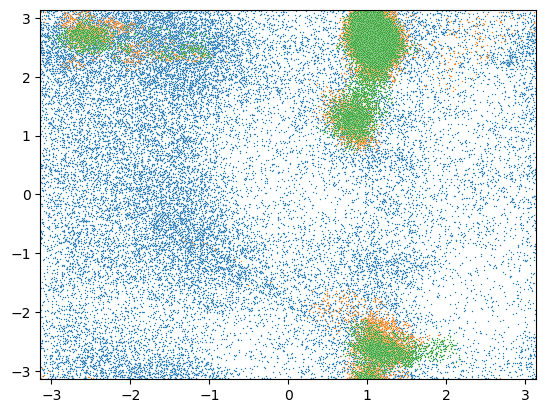

In [46]:
samples, energy = run_annealing(chain_length=1000, num_chains=30)

In [31]:
print(samples[0, -1, :, 0])


[8.86673854 8.51418112 8.43291279 8.87309479 9.04797828 8.46866039
 7.94156054 8.89431834 7.62218177 7.60948347]


In [28]:
print(samples[1, 0, :, 0])

[8.50253876 8.44454267 8.44454267 8.44454267 7.63946889 7.63946889
 7.63946889 7.63946889 7.63946889 7.63946889]


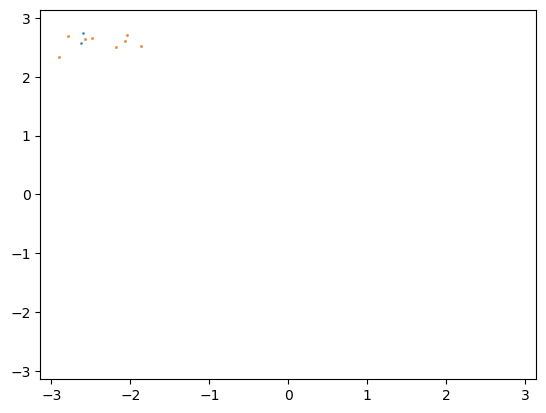

In [44]:

def pl(i):
    subsampled = samples[i, -1, :, :]
    trajectory = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')
    trajectory.xyz=nnp.array(nnp.reshape(subsampled, (subsampled.shape[0], 688, 3)))[::1]
    unitC = nnp.array([(subsampled.shape[0])*[nnp.diag(mol.box[:,0])]]).squeeze()
    trajectory.unitcell_vectors = unitC # traj.unitcell_vectors[:10000]
    angles = md.compute_dihedrals(trajectory, [phi_indices, psi_indices])

    sns.scatterplot(x = angles[:, 0], y = angles[:, 1], s=4)
    plt.xlim(-math.pi, math.pi)
    plt.ylim(-math.pi, math.pi)
    
    indices = [0, 1, 1, 2,3,4,5,6,8,8]
    # [1, 2, 2, 2, 9, 9, 9, 9, 9, 9]
    subsampled = nnp.take(samples[i, -1, :, :], nnp.array(indices), axis=0)
    trajectory = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')
    trajectory.xyz=nnp.array(nnp.reshape(subsampled, (subsampled.shape[0], 688, 3)))[::1]
    # unitC = nnp.array([(subsampled.shape[0])*[nnp.diag(mol.box[:,0])]]).squeeze()
    # trajectory.unitcell_vectors = unitC # traj.unitcell_vectors[:10000]
    angles = md.compute_dihedrals(trajectory, [phi_indices, psi_indices])

    sns.scatterplot(x = angles[:, 0], y = angles[:, 1], s=4)
    plt.xlim(-math.pi, math.pi)
    plt.ylim(-math.pi, math.pi)

# pl(0)
# pl(1)
pl(2)

In [12]:
samples[0, :, 1, :]

Array([[ 8.41858634,  8.88445851, 13.27638353, ...,  6.25726626,
        13.91314011,  2.49078518],
       [ 8.31399963,  8.89947994, 13.32675802, ...,  6.25171223,
        13.7608975 ,  2.78416623],
       [ 8.18332314,  8.87002906, 13.42442579, ...,  6.17550536,
        13.64891259,  3.04200563],
       [ 8.13586333,  8.84383878, 13.58143679, ...,  6.18294545,
        13.62256921,  3.41953941],
       [ 8.20029367,  8.9364405 , 13.61816643, ...,  6.04149493,
        13.62236161,  3.59101334]], dtype=float64)

eps Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>, sigma =Traced<ShapedArray(float64[2064])>with<DynamicJaxprTrace(level=2/0)>, grad_nlogp(1)=(Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>, Traced<ShapedArray(float64[2064])>with<DynamicJaxprTrace(level=2/0)>)
eps: 5.24000776241689, L: 157.20023287250672
eps: 1.5936861437850638, L: 47.810584313551914
eps: 1.435035226488951, L: 43.05105679466853
(3, 1000, 20, 2064) shape



(3, 1000, 20)
(20000, 2064) shape
(20000, 2064) shape
(20000, 2064) shape


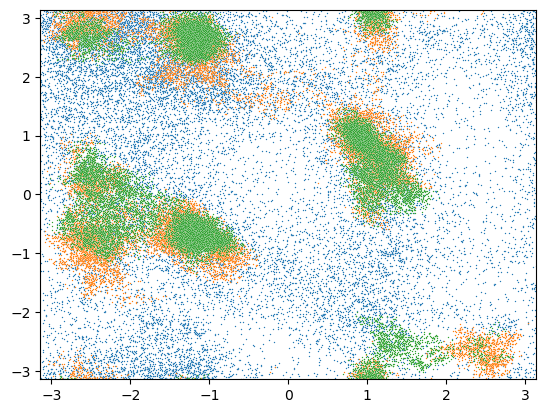

In [12]:
samples, energy = run_annealing(chain_length=1000, num_chains=20)

In [13]:
(nnp.square(energy[0,1:,0]-energy[0,:-1,0])/math.prod(pos.shape)).mean()
# energy.shape

Array(74083167.958941, dtype=float64)

eps Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>, sigma =Traced<ShapedArray(float64[2064])>with<DynamicJaxprTrace(level=2/0)>, grad_nlogp(1)=(Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>, Traced<ShapedArray(float64[2064])>with<DynamicJaxprTrace(level=2/0)>)
eps: 5.24000776241689, L: 157.20023287250672
eps: 1.5936861437850638, L: 47.810584313551914
eps: 1.435035226488951, L: 43.05105679466853
(3, 1000, 40, 2064) shape



(3, 1000, 40)
(40000, 2064) shape
(40000, 2064) shape
(40000, 2064) shape


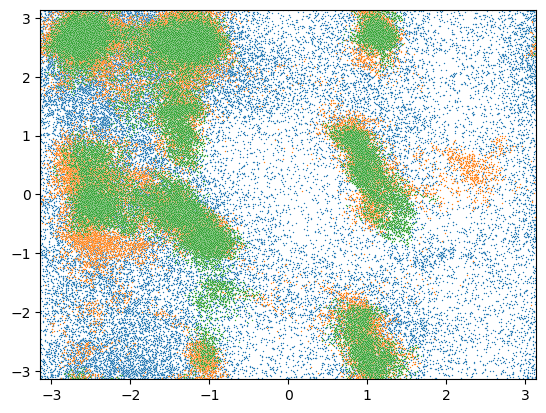

In [14]:
samples, energy = run_annealing(chain_length=1000, num_chains=40)

eps: 5.24000776241689, L: 157.20023287250672
eps: 1.5936861437850638, L: 47.810584313551914
eps: 1.435035226488951, L: 43.05105679466853
(3, 1000, 100, 2064) shape



(100000, 2064) shape
(100000, 2064) shape
(100000, 2064) shape


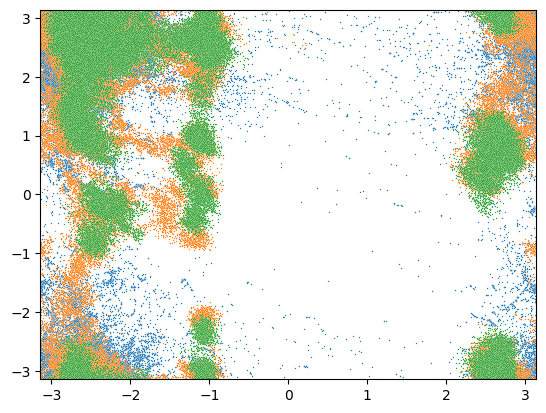

In [15]:
samples, energy = run_annealing(chain_length=100, num_chains=10)

(3, 1000, 20, 2064) shape



(20000, 2064) shape
(20000, 2064) shape
(20000, 2064) shape


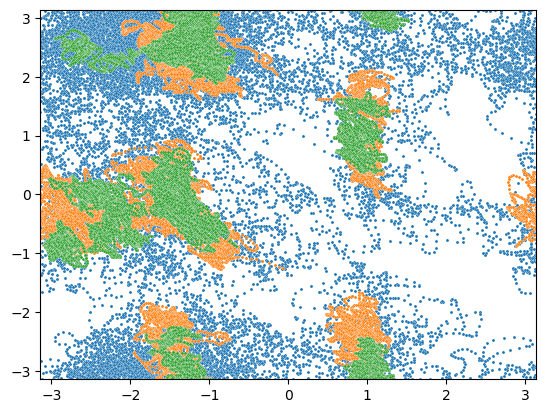

In [19]:
samples = run_annealing()

In [10]:
samples

Array([[ 8.70027873,  9.00979672, 13.45309821, ...,  7.60826945,
        13.8621789 ,  1.36142958],
       [ 8.70027272,  9.00978482, 13.453091  , ...,  7.60827557,
        13.86218826,  1.36141542]], dtype=float64)

In [13]:
samples

Array([[ 8.70029678,  9.00977255, 13.45307429, ...,  7.60830049,
        13.86214983,  1.36142364],
       [ 8.70028747,  9.00978046, 13.45311158, ...,  7.60832062,
        13.86218595,  1.3614236 ]], dtype=float64)

# Dataset for system with more solvent

In [108]:
# traj = md.load('/Users/reubencohn-gordon/Downloads/ala2 2/sim4/trajectory.dcd', top='/Users/reubencohn-gordon/Downloads/ala2 2/ala2.pdb')
# angles3 = md.compute_dihedrals(traj, [phi_indices, psi_indices])
# # # unitC = nnp.array([(len(traj)//100)*[nnp.diag(mol.box[:,0])]]).squeeze()

# sns.scatterplot(x = angles3[::1, 0], y = angles3[::1, 1])
# plt.xlim(-math.pi, math.pi)
# plt.ylim(-math.pi, math.pi)

# # trajectory2.xyz.shape